# Regression for bike-sharing-demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train = pd.read_csv('~/aiffel/bike_regression/data/bike-sharing-demand/train.csv') # 데이터 가져오기
# train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


##  EDA & Feature Engineering

In [2]:
# 날짜를 object에서 datetime으로 변경
train['datetime'] = pd.to_datetime(train['datetime'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
# datatime 분해
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day # 나중에 추가됨
train['hour'] = train['datetime'].dt.hour 
train['minute'] = train['datetime'].dt.minute #나중에 추가됨
train['second'] = train['datetime'].dt.second # 나중에 추가됨
train['dayofweek'] = train['datetime'].dt.dayofweek # dayofweek: Monday(0), Sunday(6)

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [6]:
df_time=train.loc[:,'year':'second']
df_time.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'second'], dtype='object')

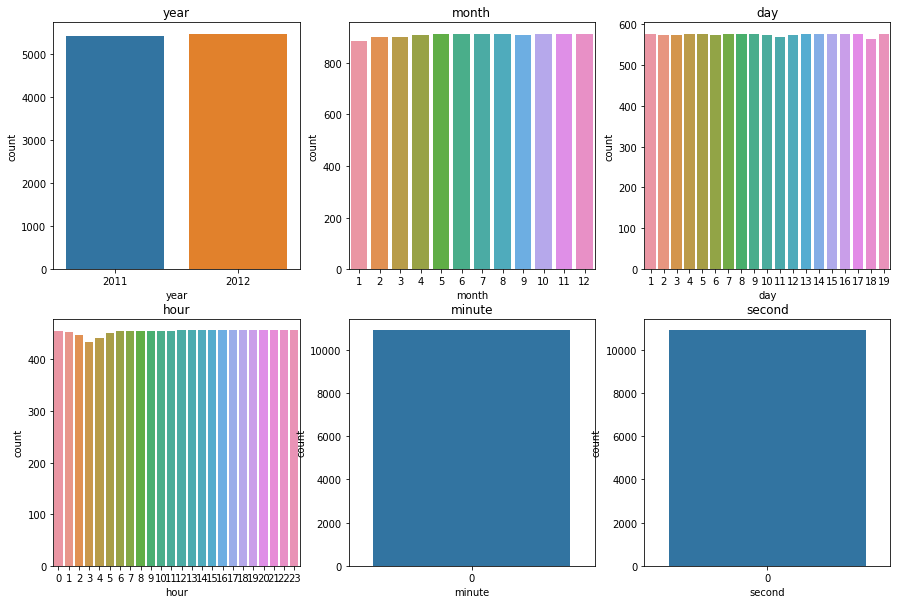

In [7]:
# subplots 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot countplots for each column
for i, col in enumerate(df_time.columns):
    sns.countplot(x=col, data=df_time, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col)

# plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='year', ylabel='count'>

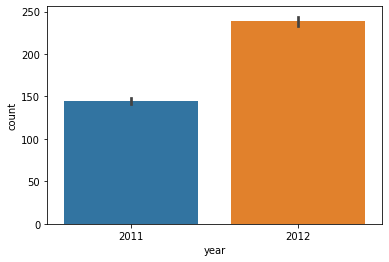

In [8]:
# 2012년도에 사용량이 상대적으로 증가했다.
sns.barplot(data = train, x = 'year', y = 'count',palette='tab10')

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


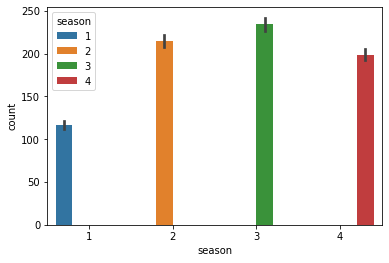

In [9]:
# 봄(1), 여름(2), 가을(3), 겨울(4)
# 겨울의 사용량의 봄보다 상대적으로 높다? 계절의 구분이 의심스럽다. 단순하게 겨울이 10/11/12월로 구분됐다.
sns.barplot(data = train, x = 'season', y = 'count', hue='season', palette='tab10')

print(train[train['season']==1].month.unique(),
      train[train['season']==2].month.unique(),
      train[train['season']==3].month.unique(),
      train[train['season']==4].month.unique(),sep='\n')

<AxesSubplot:xlabel='month', ylabel='count'>

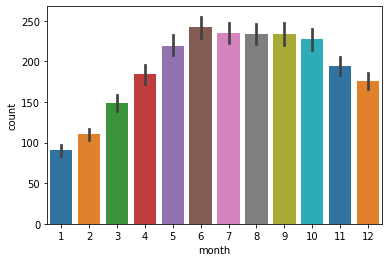

In [10]:
# 년중 따듯한 기간에 사용량이 더 많았다.
sns.barplot(data = train, x = 'month', y = 'count', palette='tab10')

<AxesSubplot:xlabel='hour', ylabel='count'>

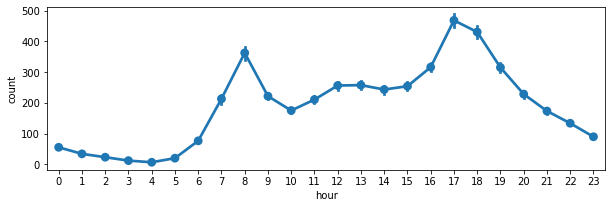

In [11]:
# 8시, 17시 출퇴근 시간대에 피크를 나타냄
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
sns.pointplot(data=train, x='hour', y='count', ax=ax1)

<AxesSubplot:xlabel='hour', ylabel='count'>

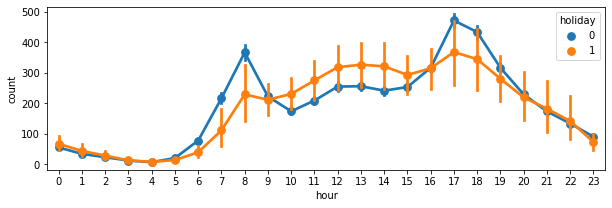

In [12]:
# 시간대를 holiday(1), non-holiday(0) 로 나누어 봄, 비휴일 출퇴근 시간대에 높은 사용량
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
sns.pointplot(data=train, x='hour', y='count', hue='holiday', ax=ax1)

<AxesSubplot:xlabel='hour', ylabel='count'>

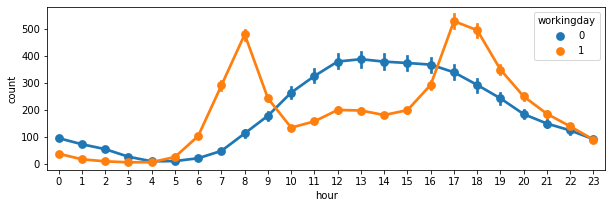

In [13]:
# 시간대를 workingday(주말/휴일 제외:1), non-workingday(주말/휴일:0) 로 나누어 봄, 근무일 출퇴근 시간대에 높은 사용량
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax1)

<AxesSubplot:xlabel='hour', ylabel='count'>

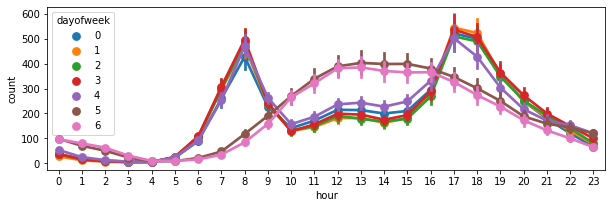

In [14]:
# 월(0)~일(6)
# holiday, workingday 결과와 다르지 않음
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', palette='tab10', ax=ax1)

<AxesSubplot:xlabel='hour', ylabel='count'>

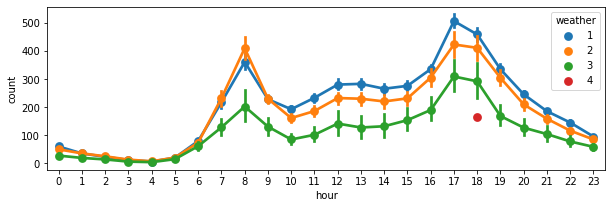

In [15]:
# 맑은날(1), 안개와 구름(2), 약한 눈과 비(3), 눈과 비(4)
# 예상대로 맑은 날일 수록 사용량이 많음
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
sns.pointplot(data=train, x='hour', y='count', hue='weather', palette='tab10', ax=ax1)

1313

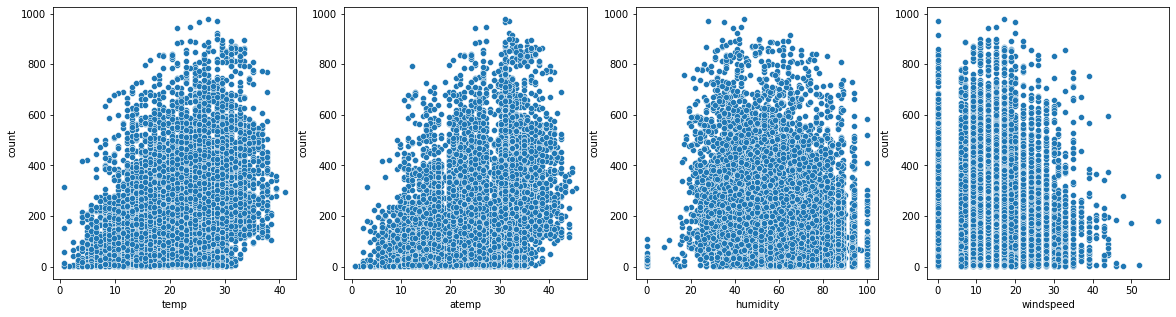

In [16]:
# temp(온도)와 atemp(체감온도)는 구분의 의미가 없다고 판단된. 바람세기가 0인 경우는 계측기준치 미달로 판단함
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize=(20,5))

sns.scatterplot(data = train, x = 'temp', y = 'count', ax = ax1)
sns.scatterplot(data = train, x = 'atemp', y = 'count', ax = ax2)
sns.scatterplot(data = train, x = 'humidity', y =  'count', ax = ax3)
sns.scatterplot(data = train, x = 'windspeed', y = 'count', ax = ax4)

train[train.windspeed==0].windspeed.count()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


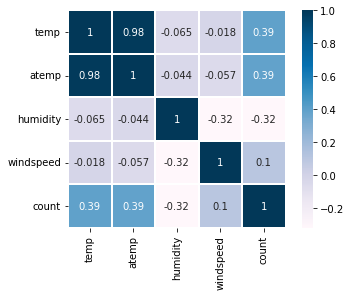

In [17]:
# 연속형변수간의 상관관계
# 위에서 살펴본 대로 'atemp'는 'temp'와 상관관계가 높아서 변수에서 제외하기로 함
corr_data = train[['temp', 'atemp', 'humidity', 'windspeed','count']]

colormap = plt.cm.PuBu
sns.heatmap(corr_data.corr(), linewidths = 0.1, square = True, annot = True, cmap = colormap )

corr_data.corr()

### - outlier제거

<AxesSubplot:xlabel='count'>

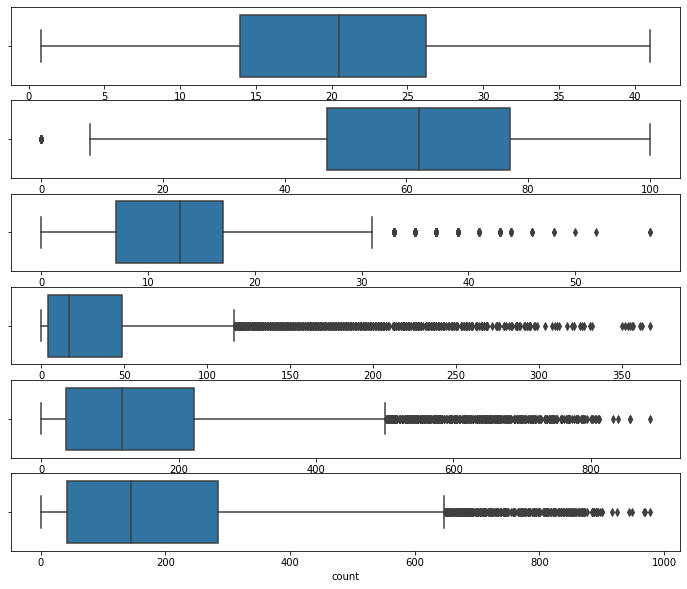

In [18]:
# 연속형변수의 분포를 살펴봄
# count(casual+registered)에서 outlier가 많이 보여짐
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12,10))
sns.boxplot(data = train, x = 'temp', ax = ax1)
sns.boxplot(data = train, x = 'humidity', ax = ax2)
sns.boxplot(data = train, x = 'windspeed', ax = ax3)
sns.boxplot(data = train, x = 'casual', ax = ax4)
sns.boxplot(data = train, x = 'registered', ax = ax5)
sns.boxplot(data = train, x = 'count', ax = ax6)

skewness_temp: 0.003691
kurtosis_temp: 1.300093
skewness_humidity: -0.086335
kurtosis_humidity: 1.300093
skewness_windspeed: 0.588767
kurtosis_windspeed: 1.300093
skewness_casual: 2.495748
kurtosis_casual: 1.300093
skewness_registered: 1.524805
kurtosis_registered: 1.300093
skewness_count: 1.242066
kurtosis_count: 1.300093


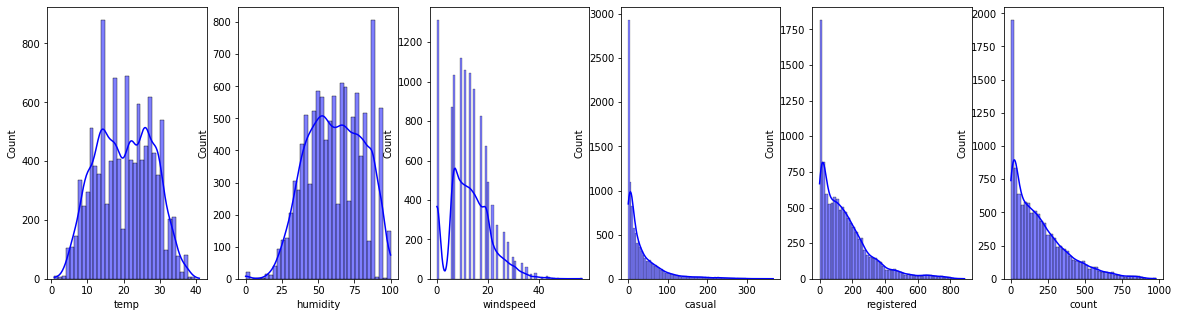

In [19]:
# count관련 skewness가 좋지 않아 정규화가 필요해 보임
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize = (20, 5))

sns.histplot(train['temp'], color = 'b', kde='true',ax = ax1)
sns.histplot(train['humidity'], color = 'b', kde='true',ax = ax2)
sns.histplot(train['windspeed'], color = 'b', kde='true',ax = ax3)
sns.histplot(train['casual'], color = 'b', kde='true',ax = ax4)
sns.histplot(train['registered'], color = 'b', kde='true',ax = ax5)
sns.histplot(train['count'], color = 'b', kde='true',ax = ax6)

print('skewness_temp: %f' %train['temp'].skew(), 'kurtosis_temp: %f' %train['count'].kurt(), sep='\n',end='\n')
print('skewness_humidity: %f' %train['humidity'].skew(), 'kurtosis_humidity: %f' %train['count'].kurt(), sep='\n',end='\n')
print('skewness_windspeed: %f' %train['windspeed'].skew(), 'kurtosis_windspeed: %f' %train['count'].kurt(), sep='\n',end='\n')
print('skewness_casual: %f' %train['casual'].skew(), 'kurtosis_casual: %f' %train['count'].kurt(), sep='\n',end='\n')
print('skewness_registered: %f' %train['registered'].skew(), 'kurtosis_registered: %f' %train['count'].kurt(), sep='\n',end='\n')
print('skewness_count: %f' %train['count'].skew(), 'kurtosis_count: %f' %train['count'].kurt(), sep='\n',end='\n')

In [20]:
# 연속형변수에서 multiple outlier(1개 이상) list 생성
# count=casual+registered 이므로 count는 빼고 반영
from collections import Counter

def detect_outliers(data, n, cols):
    outlier_indices = []
    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]

    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 1, ["temp", "humidity", "windspeed", "casual", "registered"])

In [21]:
len(Outliers_to_drop)

53

In [22]:
train.shape

(10886, 19)

In [23]:
# outlier 행을 제거
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
train.shape

(10833, 19)

### - log scaling

skewness: -0.974471
kurtosis: 0.245873


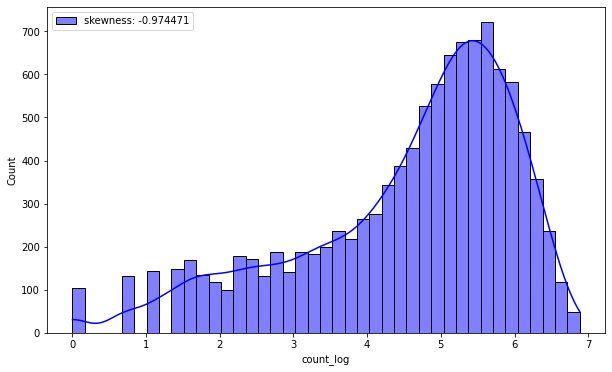

In [24]:
# 최종적으로 count를 종속변수로 사용하기에 'count' feature에 대해 정규화시켜줌
# lambda함수를 사용해서 log를 취해준 count값을 count_log 컬럼으로 생성해주고, 나중에 다시 exponentialize해서 환원한다.
train['count_log'] = train['count'].map(lambda i:np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(1,1, figsize = (10, 6))
graph = sns.histplot(train['count_log'], kde='true', color = 'b', label = 'skewness: {:2f}'.format(train['count_log'].skew()), ax = ax)
graph = graph.legend(loc = 'best')

print("skewness: %f" %train['count_log'].skew())
print("kurtosis: %f" %train['count_log'].kurt())

In [25]:
# 필요없는 count값 없애주기
train.drop('count', axis = 1, inplace = True)

### - feature selection

In [26]:
# EDA한 결과를 바탕으로 중복되는 부분을 제외하고 workingday, weather, temp, humidity, windspeed, year, month, hour, dayofweek, count_log을 남김
train.drop(['datetime','season','holiday','atemp','casual','registered','day','minute','second'], axis=1, inplace=True)

In [27]:
print(train.columns, sep='\n')

Index(['workingday', 'weather', 'temp', 'humidity', 'windspeed', 'year',
       'month', 'hour', 'dayofweek', 'count_log'],
      dtype='object')


### - one-hot encoding

In [28]:
train= pd.get_dummies(train, columns=['workingday','weather','year','month','hour','dayofweek'], dtype=int)

print(train.head(),sep='\n')

   temp  humidity  windspeed  count_log  workingday_0  workingday_1  \
0  9.84        81        0.0   2.772589             1             0   
1  9.02        80        0.0   3.688879             1             0   
2  9.02        80        0.0   3.465736             1             0   
3  9.84        75        0.0   2.564949             1             0   
4  9.84        75        0.0   0.000000             1             0   

   weather_1  weather_2  weather_3  weather_4  ...  hour_21  hour_22  hour_23  \
0          1          0          0          0  ...        0        0        0   
1          1          0          0          0  ...        0        0        0   
2          1          0          0          0  ...        0        0        0   
3          1          0          0          0  ...        0        0        0   
4          1          0          0          0  ...        0        0        0   

   dayofweek_0  dayofweek_1  dayofweek_2  dayofweek_3  dayofweek_4  \
0            0  

In [29]:
print(train.columns, sep='\n')

Index(['temp', 'humidity', 'windspeed', 'count_log', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6'],
      dtype='object')


### - train_test 분리

In [38]:
X = train.drop('count_log',axis=1).values
y= train['count_log'].values

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8666, 54) (8666,)
(2167, 54) (2167,)


## LinearRegression model 적용

In [40]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [41]:
model.fit(X_train, y_train)

LinearRegression()

In [42]:
predictions = model.predict(X_test)
predictions

array([4.93405914, 6.58500671, 5.36803055, ..., 4.0220108 , 4.8328476 ,
       4.49850845])

### - log적용된 값을 exponentialize해서 환원 후 비용함수계산

In [49]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
rmse = np.sqrt(mse)

print('MSE: {:.4f}'.format(mse))
print('RMSE: %.4f' % rmse)

MSE: 8535.4194
RMSE: 92.3873


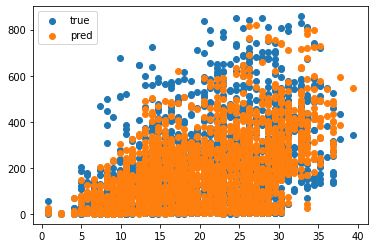

In [48]:
# temp-count 관계 
plt.scatter(X_test[:,0], np.exp(y_test), label="true")
plt.scatter(X_test[:,0], np.exp(predictions), label="pred")
plt.legend()
plt.show()

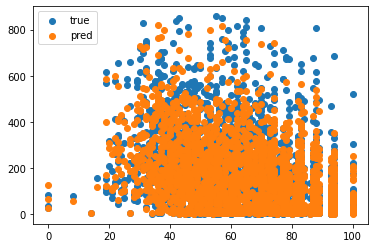

In [45]:
# humidity-count 관계
plt.scatter(X_test[:,1], np.exp(y_test), label="true")
plt.scatter(X_test[:,1], np.exp(predictions), label="pred")
plt.legend()
plt.show()

## Retrospect

* matplotlib, seaborn을 review 및 정리할 필요가 있다.